In [1]:
# Import Skleaen libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
# Import other Libraries
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from scipy import stats
sns.set()


In [3]:
# Separate Good and Bad Customers Data
temp_data = pd.read_csv("C:\Project_Files\Capstone1_Files\German_CreditRating_Cleaned_Data.csv")
print("shape of the Original data",temp_data.shape)
good_customers = temp_data[temp_data['credibility'] == 1]
bad_customers = temp_data[temp_data['credibility'] == 0]

shape of the Original data (1000, 21)


In [4]:
def binary_transformation(data):
    numerical_data = data[['duration','credit_amount','age']]
    credibility_data = data['credibility']
    data.drop(['duration','credit_amount','age','credibility'],axis=1,inplace=True)
    data = pd.concat([pd.get_dummies(data[col]) for col in data],axis=1,keys=data.columns)
    data[['duration','credit_amount','age']] = numerical_data
    return (data,credibility_data)

In [11]:
# Tuning LinearSVC using C hyperparameter
def FineTune_SVC(X_train,y_train):
    SVC_steps = [("Scaler",StandardScaler()),
                       ("svc_clf",SVC(kernel="linear"))]
    svc_pipeline = Pipeline(SVC_steps)

    # parameters of an Estimator  -->  svc_clf.get_params().keys()

    parameters_svc = dict(svc_clf__C=[0.0001,0.001,0.01,0.1,1,10])
    grid_svc = GridSearchCV(svc_pipeline,param_grid=parameters_svc,cv=5)
    grid_svc_result = grid_svc.fit(X_train,y_train)
    print("Best Hyperparameter for Linear Kernal SVC: %f using %s" %(grid_svc_result.best_score_,grid_svc_result.best_params_))
    return (grid_svc_result.best_params_)

In [12]:
# Evaluation on Test Data for SVC kernel Linear
def test_evaluation(X_train,X_test,y_train,y_test,c_value):
    scaler = StandardScaler().fit(X_train)
    scaled_Xtrain = scaler.transform(X_train)
    model = SVC(kernel="linear",C=c_value,probability=True)
#   print(model.get_params().keys())
    model.fit(scaled_Xtrain,y_train)
    scaled_Xtest = scaler.transform(X_test)
    predicted_y = model.predict(scaled_Xtest)
    print("")
    print("Accuracy score on Test is : %s"%accuracy_score(y_test, predicted_y))
    print("")
    proba = model.predict_proba(scaled_Xtest)
    return(proba[:,1])

In [23]:
def thresh_cost_function(proba_val):
    thresh_val = 0
    thresh_vals=[]
    profit_vals=[]
    for k  in range(1,21):
        predicted_y=[]       
        thresh_val = thresh_val+ 0.05
        thresh_vals.append(thresh_val)
#        print ("threshold value",thresh_val)
        for prob in proba_val:
        
            if (prob > thresh_val):
                predicted_y.append(1)
            else:predicted_y.append(0)
        cost_params = confusion_matrix(y_test, predicted_y)
        profit_val=0
        def cost_function(matrix):
            Cost_Function = (matrix[1][1] * .30) - (matrix[0][1] * .75) - (matrix[1][0] * .30)
            Total_Loss = Cost_Function * 30000
#            print("Total Loss incurred by the Bank ",Total_Loss,"DM")
            return(Total_Loss)
        profit_val=cost_function(cost_params)
        profit_vals.append(profit_val)
   
#    plt.plot(profit_vals,thresh_vals,linewidth=2,label=None)
#    plt.axis([np.amin(profit_vals),np.amax(profit_vals), 0, 1])
    plt.plot(thresh_vals,profit_vals,linewidth=2,label=None)
    plt.axis([ 0, 1,np.amin(profit_vals),np.amax(profit_vals)])
    plt.title("Measure of Cost based on Credibility")
    plt.xlabel("Threshold Values")
    plt.ylabel("Profit from Prediction")
    plt.show()

In [ ]:
Let us assume that a correct decision of the bank would result in a Profit of 30% on Average. A correct decision here means that the bank predicts an application to be good or credit-worthy and it actually turns out to be credit worthy. When the opposite is true, i.e. bank predicts the application to be good but it turns out to be bad credit, then the loss is about 75% on average. If the bank predicts an application to be non-creditworthy, then loan facility is not extended to that applicant and bank does not incur any loss (opportunity loss is not considered here).

The margin of profit acquired by the Banks can be calculated by considering the 3 factors
   * profit from Good Customers
   * Loss from incorrect Good Customers 
   * Loss of Profit from incorrect Bad Customers

This can be translated into cost function for evaluating the perfomance of models
   * Cost_function = (Total no of Good Customers x profit percentage) - (Total no of incorrect Good Customers x Loss percentage) - (Total no of Incorrect Bad Customers x Profit Percentage)            


In [11]:
# ROC Curve function
def plot_roc_curve(y_test,y_scores):
    fpr,tpr,_ = roc_curve(y_test,y_scores)
    #print(fpr)
    #print(tpr)
    plt.plot(fpr,tpr,linewidth=2,label=None)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


Number of good customers data :-  100
Number of bad customers data :-   300


Best Hyperparameter for Linear Kernal SVC: 0.743750 using {'svc_clf__C': 0.0001}

Accuracy score on Test is : 0.775



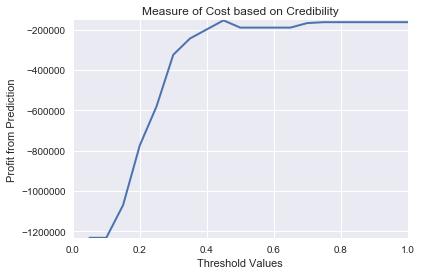


Number of good customers data :-  200
Number of bad customers data :-   300


Best Hyperparameter for Linear Kernal SVC: 0.732500 using {'svc_clf__C': 0.01}

Accuracy score on Test is : 0.66



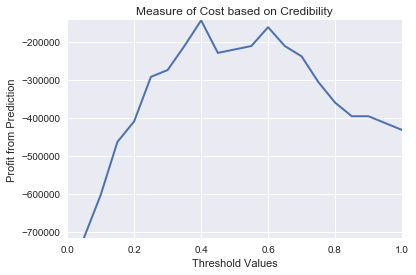


Number of good customers data :-  300
Number of bad customers data :-   300


Best Hyperparameter for Linear Kernal SVC: 0.731250 using {'svc_clf__C': 0.001}

Accuracy score on Test is : 0.725



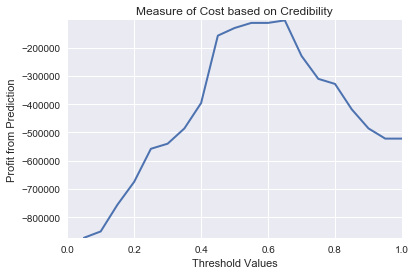


Number of good customers data :-  400
Number of bad customers data :-   300


Best Hyperparameter for Linear Kernal SVC: 0.725000 using {'svc_clf__C': 0.01}

Accuracy score on Test is : 0.664285714286



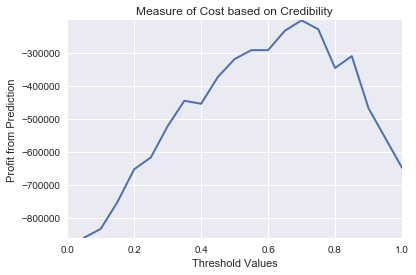


Number of good customers data :-  500
Number of bad customers data :-   300


Best Hyperparameter for Linear Kernal SVC: 0.720313 using {'svc_clf__C': 0.1}

Accuracy score on Test is : 0.6875



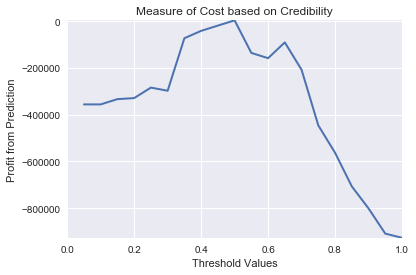


Number of good customers data :-  600
Number of bad customers data :-   300


Best Hyperparameter for Linear Kernal SVC: 0.747222 using {'svc_clf__C': 0.01}

Accuracy score on Test is : 0.738888888889



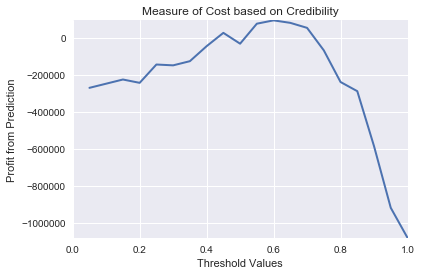


Number of good customers data :-  700
Number of bad customers data :-   300


Best Hyperparameter for Linear Kernal SVC: 0.747500 using {'svc_clf__C': 0.1}

Accuracy score on Test is : 0.755



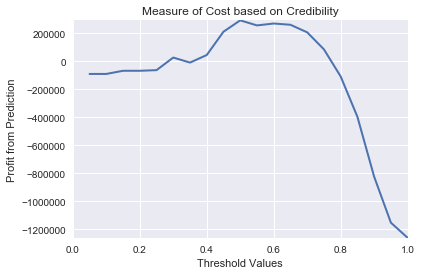

In [26]:
# Undersampling Good Customer Instances to have 1:1 ratio between Good and Bad Customers data
sample_good = [100,200,300,400,500,600,700]
for size in sample_good:
    good_data = good_customers.sample(n=size,random_state=42)
    print("==========================================================================================================") 
    print("")
    print("Number of good customers data :- ",good_data.shape[0])
    print("Number of bad customers data :-  ",bad_customers.shape[0])
    sample_data = pd.concat([bad_customers,good_data])
    sample_data,target = binary_transformation(sample_data)
    print("")  
# Split the data between Training and Test
    X_train,X_test,y_train,y_test = train_test_split(sample_data,target,test_size=0.20,random_state=42)
    print("")
# fine tune hyperparameters for linear Svc
    best_param = FineTune_SVC(X_train,y_train)
    
# Get the Confusion Matrix for Performance Metrics
    good_proba= test_evaluation(X_train,X_test,y_train,y_test,best_param['svc_clf__C'])
    thresh_cost_function(good_proba)
    print("==========================================================================================================")
    

* SVC model with Linear Kernal is performing better than other models with an Accuracy of .755 when the hyperparameter C is 0.1 and the raito between good and bad customers is 7:3.The cost function generates more profit margin by having better recall for good customers than Bad customers thereby increasing the net revenue of the banks.